# Reto Twitter

Este cuaderno usa los datos del grafo del club de karate de Zachary, y aplica diferentes algoritmos de detección de comunidades. Aquí se explorarán diferentes algoritmos, formas de medir la calidad de la comunidad y algoritmos para clasificar nuevos clientes en alguna de las comunidades. También se exploran algunos algoritmos de modelación de temas en texto, que se usarán para identificar los intereses de nuestros clientes.

In [2]:
# Librerías para detección de comunidades
import pandas as pd
from itertools import chain, combinations
import matplotlib.pyplot as plt

import networkx as nx
import community as community_louvain
from networkx.algorithms import community
from cdlib import algorithms
from cdlib.classes.edge_clustering import EdgeClustering


# Librerías para procesar texto
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

## El club de karate de Zachary

Este grafo es un pequeño ejemplo que suele usarse para probar diferentes algoritmos de comunidades, y está incluido en *networkx*.

C:\Users\david\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


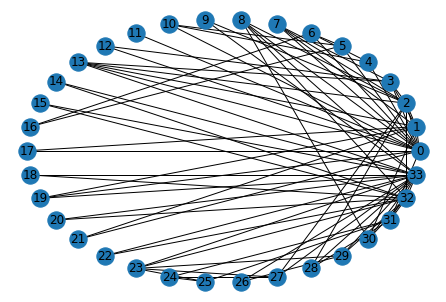

In [12]:
G = nx.karate_club_graph()
nx.draw_circular(G, with_labels=True)
plt.show()

## Community detection

Estos algoritmos deberían ayudarnos a identificar grupos sociales dentro de nuestros clientes

In [14]:
def community_to_df(G, algorithm, overlapping = False):
    '''
    Retorna un dataframe con dos columnas. La primera columna contiene el nodo del grafo y la segunda
    columna contiene los arreglos o el escalar que indican a qué comunidades o qué comunidad pertenece.

            Parametros:
                    G: Grafo
                    algorithm: Output del algoritmo de comunidades
                    overlapping: Booleano que indica si el algoritmo tiene comunidades que se solapan

            Returna:
                    df_nodes (DataFrame): Dataframe con dos columnas
    '''
    if type(algorithm) is dict:
        df_nodes = pd.DataFrame([algorithm]).T.reset_index()
        df_nodes.columns = ['node', 'community']
        
    elif type(algorithm) == EdgeClustering:

        dictionary = algorithm.to_edge_community_map()
        nodes = {}

        for i, j in dictionary:
            if i in nodes and dictionary[i, j][0] not in nodes[i]:
                nodes[i].extend(dictionary[i, j])
            elif i not in nodes:
                nodes[i] = dictionary[i, j]
    
            if (j in nodes) and (dictionary[i, j][0] not in nodes[j]):
                nodes[j].extend(dictionary[i, j])
            elif j not in nodes:
                nodes[j] = dictionary[i, j]
                
            df_nodes = pd.DataFrame(list(nodes.items()), columns = ['node', 'community'])
            
    else:
        df_nodes = pd.DataFrame(G.nodes, columns = ['node'])
        df_nodes['community'] = [[]] * df_nodes.shape[0]

        community_number = 0
        for community_found in algorithm:
            location = df_nodes.node.isin([node for node in community_found])
            if overlapping is False:
                df_nodes.loc[location, 'community'] = community_number
            else:
                df_nodes.loc[location, 'community'] = df_nodes.loc[location, 
                                                       'community'].apply(lambda x: 
                                                                          [*[value for value in x], community_number])
        
            community_number += 1
    
    return df_nodes

#### Función de comunidades a dataframe

 - Se prueba la función con los algoritmos que hasta el momento vemos que puede manejar.

In [15]:
print('Bisección de grafo')
algorithm = community.kernighan_lin_bisection(G)
df = community_to_df(G, algorithm)
print(df.head())

print('Percolación de cliques')
number_of_shared_edges = 3

algorithm = community.k_clique_communities(G, number_of_shared_edges)
df = community_to_df(G, algorithm, overlapping = True)
print(df.head())

print('Maxima modularidad')
algorithm = community.greedy_modularity_communities(G)
df = community_to_df(G, algorithm)
print(df.head())

print('Label propagation')
algorithm = community.label_propagation_communities(G)
df = community_to_df(G, algorithm)
print(df.head())

print('Asyncronous fluid communities')
number_communities = 3
max_iter = 200

algorithm = community.asyn_fluidc(G, number_communities, max_iter) #Random
df = community_to_df(G, algorithm)
print(df.head())

print('Heurísticos de Lovaina')
algorithm = community_louvain.best_partition(G)
df = community_to_df(G, algorithm)
print(df.head())

print('Clustering de aristas')
algorithm = algorithms.hierarchical_link_community(G)
df = community_to_df(G, algorithm, overlapping = True)
print(df.head())

Bisección de grafo
   node community
0     0         0
1     1         0
2     2         0
3     3         0
4     4         0
Percolación de cliques
   node community
0     0    [0, 1]
1     1       [0]
2     2       [0]
3     3       [0]
4     4       [1]
Maxima modularidad
   node community
0     0         2
1     1         1
2     2         1
3     3         1
4     4         2
Label propagation
   node community
0     0         2
1     1         2
2     2         0
3     3         2
4     4         2
Asyncronous fluid communities
   node community
0     0         1
1     1         1
2     2         1
3     3         1
4     4         1
Heurísticos de Lovaina
   node  community
0     0          0
1     1          0
2     2          0
3     3          0
4     4          1
Clustering de aristas
   node           community
0     1             [0, 19]
1    17             [0, 19]
2     0  [0, 5, 16, 17, 18]
3     7  [0, 5, 16, 17, 18]
4     3                 [0]


## Tweets en español

Estos datos son tweets en español que preprocesaremos:

    - Eliminamos los caracteres especiales
    - Tokenizamos y tomamos en minúsculas las palabras
    - Eliminamos las palabras más comunes y más extrañas (top 1% y bottom 1%)
    - Eliminamos stopwords
    - Calculamos bag of words con frecuencia de términos y con tf-idf

In [16]:
url = 'https://raw.githubusercontent.com/garnachod/TwitterSentimentDataset/master/tweets_clean.txt'
df = pd.read_table(url, header=None)

In [17]:
df[0] = df[0].apply(lambda x: re.sub('[^Á-Úá-úA-Za-z ]+', ' ', x))

In [18]:
token_lists = [word_tokenize(each) for each in df[0]]
tokens = [item.lower() for sublist in token_lists for item in sublist]

one_percentile = int(len(set(tokens)) * 0.01)
top_1_percentile = Counter(tokens).most_common(one_percentile)
bottom_1_percentile = Counter(tokens).most_common()[-one_percentile:]

In [19]:
stoplist = stopwords.words('spanish')
stoplist.extend([word for word,val in top_1_percentile])
stoplist.extend([word for word,val in bottom_1_percentile])

In [20]:
tf_vectorizer = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=stoplist,
    ngram_range=(1, 1)
)

tfidf_vectorizer = TfidfVectorizer(
    tokenizer=word_tokenize,
    stop_words=stoplist,
    ngram_range=(1, 1)
)

tf = tf_vectorizer.fit_transform(df[0])
tf_feature_names = tf_vectorizer.get_feature_names()

tfidf = tfidf_vectorizer.fit_transform(df[0])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

## Topic modelling

Estos algoritmos deberían ayudarnos a identificar gustos dentro de los grupos sociales- Se prueba LDA, LSA y factorización de matrices. Los últimos dos se hacen con tf-idf y tf.

In [114]:
topics = 20

lda = LatentDirichletAllocation(topics, random_state=16)
allocate_lda = lda.fit(tf)

nmf = NMF(topics, random_state=16)
allocate_nmf_tf = nmf.fit(tf)
allocate_nmf_tfidf = nmf.fit(tfidf)

lsa = TruncatedSVD(topics, random_state=16)
allocate_lsa_tf = lsa.fit(tf)
allocate_lsa_tfidf = lsa.fit(tfidf)

C:\Users\david\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [121]:
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [116]:
display_topics(allocate_lda, tf_feature_names, no_top_words)

Topic 0:
estrena periscope mvt jtx rne invito fzjai lasmananas agenda clausura
Topic 1:
vinkio moreno comunicación faltan rol cole lanzará vicesecretario juanma anunciado
Topic 2:
feo gjulianm afiliados zombi mods sorayapp subs zombie cree innovación
Topic 3:
nose island logro podcast top paradise paradiseisland paquete gameinsight map
Topic 4:
aburrido posgrado seguidores eja ensevillapodemos phb parodiamos minuevooficio minuevovicio paulinarubio
Topic 5:
emppleo oficiales don probando universal ttip fk harry videoveranomtv murcia
Topic 6:
karmarun debatalrojovivo susanadiaz ximopresident tranquilo ainhat ximopuig teatro valencia cuento
Topic 7:
john apenas chocolate wick starbreeze recien reir lleno despierto llamar
Topic 8:
enza verg siguiente reto unidad grado vive legislatura tarea leymordaza
Topic 9:
consolas garnachod invertirenpersonas ashley mínimo madison flash aventura homenaje creadores
Topic 10:
abcdjnaz bajar gonzalezpons compras comprado feartwd creer mirar sr ncallepons

In [117]:
display_topics(allocate_nmf_tf, tfidf_feature_names, no_top_words)

Topic 0:
island logro gameinsight paradiseisland paradise llave maestra jo wnwgy divertirse
Topic 1:
eja phb paulinarubio minuevooficio minuevovicio parodiamos disfrútala disfrútenla miriamoficialgh aberronchotv
Topic 2:
fzjai interviene clausura moreno juanma escuelappa campusfaes periscope cumpplimos clm
Topic 3:
abcdjnaz david sara loca salvado kare luisreyes greaseluna marianitasse yesi
Topic 4:
monster high criticar reúnen clawdeen compañe jn qwmccpgppp lispauw xnzxuvvsbz
Topic 5:
mvt jtx síguelo clausura mitin ofrece arenas sevilla vicesecretario visita
Topic 6:
john wick starbreeze desarrollado wevr grab conten djuegos gamers gastonreyes
Topic 7:
hunt witcher wild comenzar perfecta ocasión prop djuegos estreno podcast
Topic 8:
rma elegido iwolowitz badoo majas marco asensio mm lpqygye wcilxjksvv
Topic 9:
musica escuchando duermo nose queria recomendarte rodrigo escucho olvide tranqui
Topic 10:
astrocosas pareja pelo levantar guay pienso octubre distinta varios criterio
Topic 11:

In [118]:
display_topics(allocate_nmf_tfidf, tfidf_feature_names, no_top_words)

Topic 0:
island logro gameinsight paradiseisland paradise llave maestra jo wnwgy divertirse
Topic 1:
eja phb paulinarubio minuevooficio minuevovicio parodiamos disfrútala disfrútenla miriamoficialgh aberronchotv
Topic 2:
fzjai interviene clausura moreno juanma escuelappa campusfaes periscope cumpplimos clm
Topic 3:
abcdjnaz david sara loca salvado kare luisreyes greaseluna marianitasse yesi
Topic 4:
monster high criticar reúnen clawdeen compañe jn qwmccpgppp lispauw xnzxuvvsbz
Topic 5:
mvt jtx síguelo clausura mitin ofrece arenas sevilla vicesecretario visita
Topic 6:
john wick starbreeze desarrollado wevr grab conten djuegos gamers gastonreyes
Topic 7:
hunt witcher wild comenzar perfecta ocasión prop djuegos estreno podcast
Topic 8:
rma elegido iwolowitz badoo majas marco asensio mm lpqygye wcilxjksvv
Topic 9:
musica escuchando duermo nose queria recomendarte rodrigo escucho olvide tranqui
Topic 10:
astrocosas pareja pelo levantar guay pienso octubre distinta varios criterio
Topic 11:

In [119]:
display_topics(allocate_lsa_tf, tfidf_feature_names, no_top_words)

Topic 0:
island logro gameinsight paradiseisland paradise eja phb minuevovicio parodiamos paulinarubio
Topic 1:
eja phb minuevooficio minuevovicio parodiamos paulinarubio disfrútala garnachod disfrútenla astrocosas
Topic 2:
fzjai mvt jtx clausura interviene moreno juanma síguelo escuelappa mitin
Topic 3:
abcdjnaz fzjai gcgij seguidores enza verg aburrido garnachod loca temprano
Topic 4:
monster high criticar reúnen compañe clawdeen musica garnachod cole vinkio
Topic 5:
mvt jtx john wick starbreeze astrocosas hunt musica witcher síguelo
Topic 6:
john wick starbreeze desarrollado fzjai wevr grab conten musica javipolo
Topic 7:
musica hunt witcher wild feartwd escuchando isabelvaldesque perfecta temprano comenzar
Topic 8:
rma elegido iwolowitz feartwd garnachod solicitud temprano towngameplay siete vinkio
Topic 9:
witcher hunt wild presentan aventura creadores consolas hob torchlight puzles
Topic 10:
astrocosas aventura consolas creadores presentan hob torchlight puzles rma elegido
Topic 

In [120]:
display_topics(allocate_lsa_tfidf, tfidf_feature_names, no_top_words)

Topic 0:
island logro gameinsight paradiseisland paradise eja phb minuevovicio parodiamos paulinarubio
Topic 1:
eja phb minuevooficio minuevovicio parodiamos paulinarubio disfrútala garnachod disfrútenla astrocosas
Topic 2:
fzjai mvt jtx clausura interviene moreno juanma síguelo escuelappa mitin
Topic 3:
abcdjnaz fzjai gcgij seguidores enza verg aburrido garnachod loca temprano
Topic 4:
monster high criticar reúnen compañe clawdeen musica garnachod cole vinkio
Topic 5:
mvt jtx john wick starbreeze astrocosas hunt musica witcher síguelo
Topic 6:
john wick starbreeze desarrollado fzjai wevr grab conten musica javipolo
Topic 7:
musica hunt witcher wild feartwd escuchando isabelvaldesque perfecta temprano comenzar
Topic 8:
rma elegido iwolowitz feartwd garnachod solicitud temprano towngameplay siete vinkio
Topic 9:
witcher hunt wild presentan aventura creadores consolas hob torchlight puzles
Topic 10:
astrocosas aventura consolas creadores presentan hob torchlight puzles rma elegido
Topic 

# La hora de la verdad

In [30]:
df_twitter = pd.read_table('twitter_combined.txt', header = None, sep = '\s')

C:\Users\david\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [31]:
df_twitter.head()

,0,1
0,214328887,34428380
1,17116707,28465635
2,380580781,18996905
3,221036078,153460275
4,107830991,17868918
